In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from utils import *
from utils.helpers import czi_predict_movie

In [2]:
torch.cuda.set_device(3)

In [3]:
img_data = Path('/scratch/bpho/datasets/synth_newcrap_002/')
model_path = Path('/scratch/bpho/models')
nb_name = "synth_newcrap_002_unet_mse"

In [4]:
!ls {img_data}/lr_up/train/

'10a ctcf phal-1_Airyscan Processing2_00_000_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_001_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_002_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_003_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_004_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_005_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_006_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_007_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_008_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_009_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_010_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_011_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_012_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_013_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_014_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_015_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_016_000.tif'
'10a ctcf phal-1_Airyscan Processing2_00_017_000.tif'
'10a ctcf phal-1_Airyscan Pr

'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_155.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_156.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_157.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_158.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_159.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_160.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_161.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_162.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_163.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_164.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_165.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_166.tif'
'MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10_00_000_167.tif'
'MitoTracker

In [4]:
def get_src(size=128):
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, tile_size=None, noise=None, max_zoom=8.):
    if tile_size is None: tile_size = size
    src = get_src(tile_size)
    
    tfms = [[rand_resize_crop(size=size)],[]]
    tfms = get_transforms(flip_vert=True, max_zoom=max_zoom)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    
    if not noise is None:
        tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [6]:
!ls {img_data}

hr  lr	lr_up


In [5]:
bs = 64
size = 128
data = get_data(bs, size, max_zoom=4)
data

/scratch/bpho/datasets/synth_newcrap_002/lr_up


ImageDataBunch;

Train: LabelList (7846 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/synth_newcrap_002/lr_up;

Valid: LabelList (2210 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/synth_newcrap_002/lr_up;

Test: None

In [8]:
#fn = list((img_data/'hr'/'train').glob('*.tif'))[0]
#PIL.Image.open(fn)

In [5]:
feat_loss = F.mse_loss

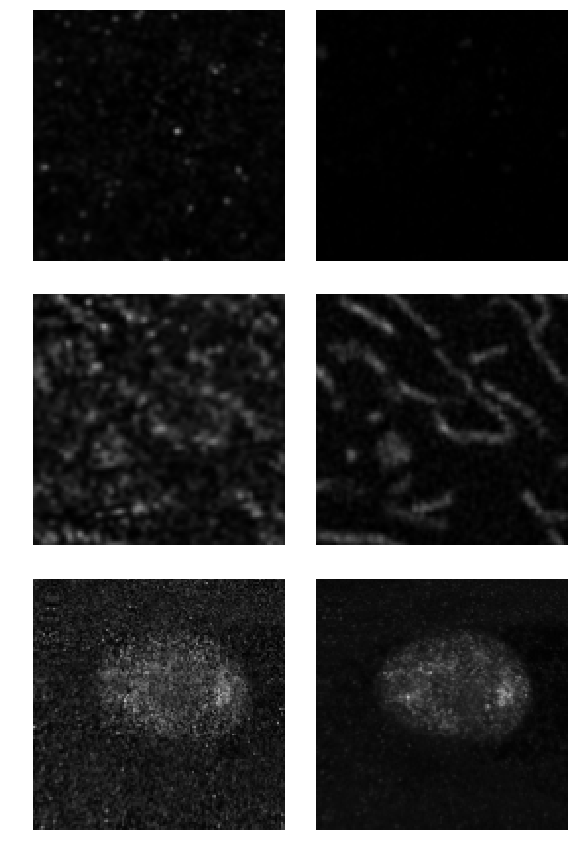

In [10]:
data.show_batch(3)

In [11]:
arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()

11899

In [12]:
#learn.lr_find()
#learn.recorder.plot()

In [7]:
lr = 1e-3

In [8]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start,
                        callbacks=[SaveModelCallback(learn, name=save_name)])
    #learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [15]:
#!ls /scratch/bpho/models

Better model found at epoch 0 with val_loss value: 0.05591461434960365.
Better model found at epoch 1 with val_loss value: 0.04421268403530121.
Better model found at epoch 2 with val_loss value: 0.0380246527493.
Better model found at epoch 3 with val_loss value: 0.03567717596888542.
Better model found at epoch 4 with val_loss value: 0.03207864984869957.
Better model found at epoch 5 with val_loss value: 0.030728381127119064.
Better model found at epoch 6 with val_loss value: 0.02908477373421192.
Better model found at epoch 7 with val_loss value: 0.027788247913122177.
Better model found at epoch 8 with val_loss value: 0.02724877931177616.
Better model found at epoch 9 with val_loss value: 0.02651839703321457.
Better model found at epoch 10 with val_loss value: 0.025595782324671745.
Better model found at epoch 11 with val_loss value: 0.02461465634405613.
Better model found at epoch 14 with val_loss value: 0.023690449073910713.
Better model found at epoch 16 with val_loss value: 0.0230803

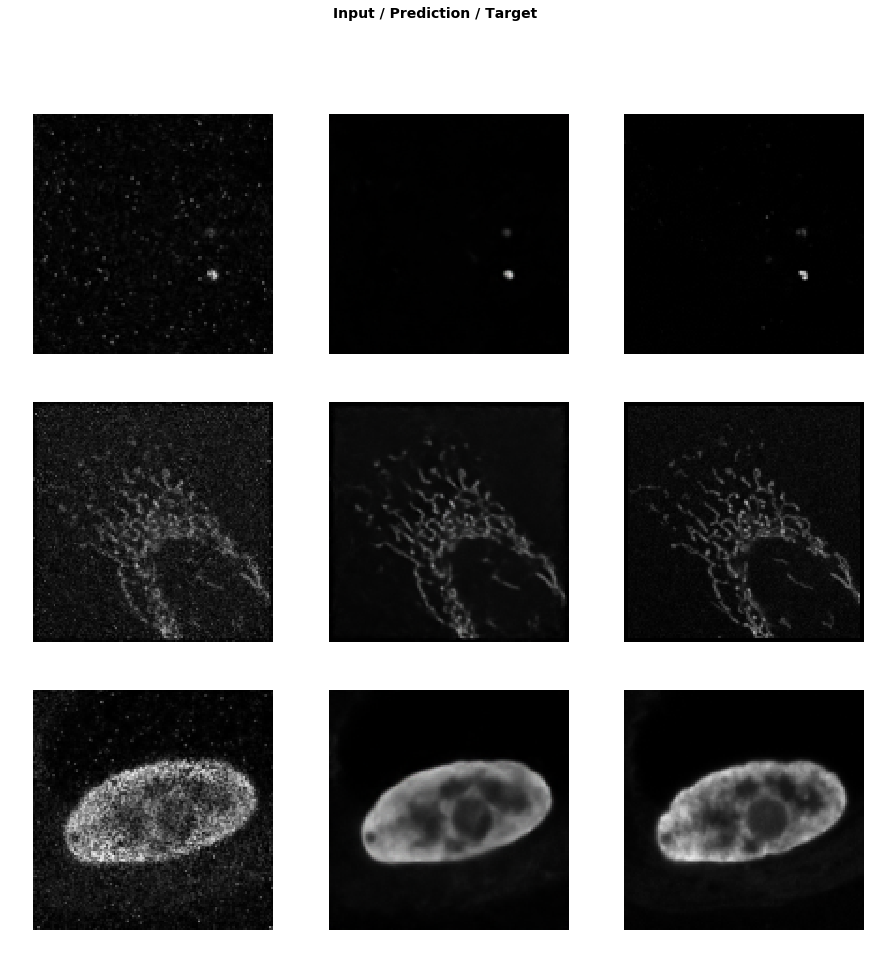

In [16]:
do_fit(f'{nb_name}.0', lr, cycle_len=100)

In [17]:
learn.unfreeze()

Better model found at epoch 0 with val_loss value: 0.0194637980312109.
Better model found at epoch 3 with val_loss value: 0.01945418491959572.
Better model found at epoch 4 with val_loss value: 0.019442401826381683.
Better model found at epoch 22 with val_loss value: 0.01942340098321438.
Better model found at epoch 47 with val_loss value: 0.01941746473312378.


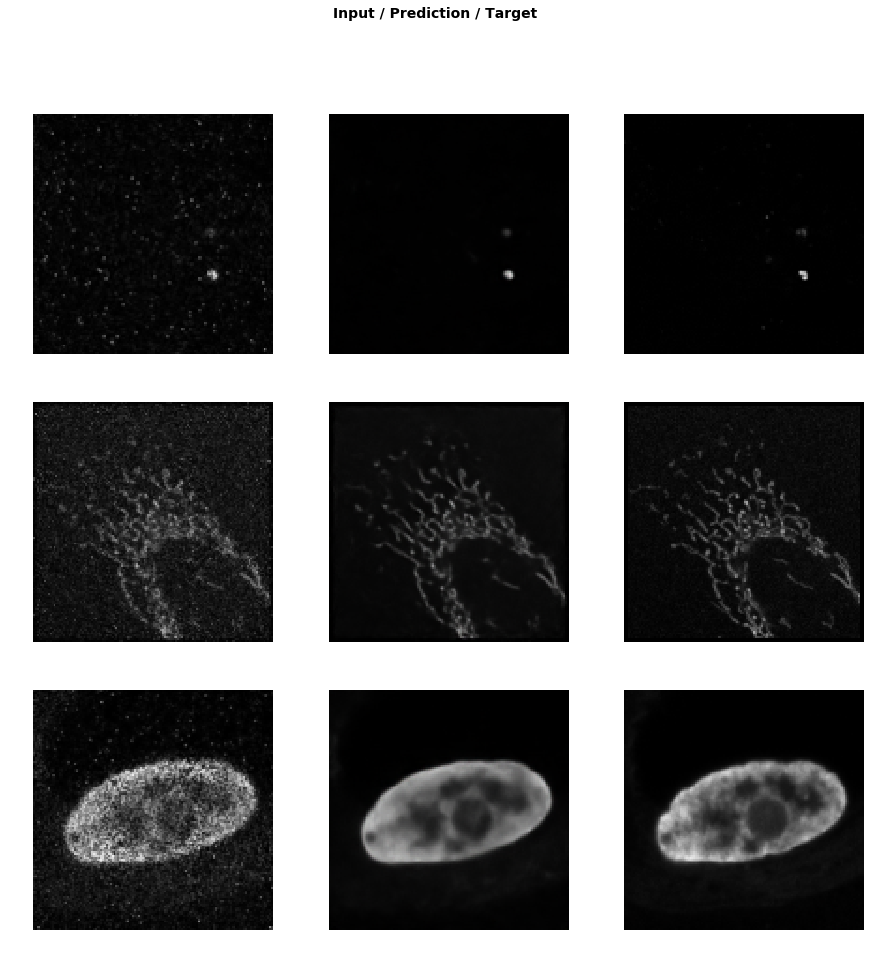

In [18]:
do_fit(f'{nb_name}.1', slice(1e-5,lr), cycle_len=50)

In [15]:
bs = 16
size = 256
data = get_data(bs, size, max_zoom=4.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics,# callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True, 
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load(f'{nb_name}.1')
gc.collect()


/scratch/bpho/datasets/synth_newcrap_002/lr_up


0

Better model found at epoch 0 with val_loss value: 0.02577962726354599.
Better model found at epoch 1 with val_loss value: 0.02568040043115616.
Better model found at epoch 2 with val_loss value: 0.025213681161403656.
Better model found at epoch 4 with val_loss value: 0.0251129399985075.
Better model found at epoch 7 with val_loss value: 0.02498755231499672.
Better model found at epoch 9 with val_loss value: 0.024671247228980064.
Better model found at epoch 12 with val_loss value: 0.024392716586589813.
Better model found at epoch 15 with val_loss value: 0.02435331419110298.
Better model found at epoch 17 with val_loss value: 0.024240335449576378.
Better model found at epoch 20 with val_loss value: 0.024178296327590942.
Better model found at epoch 21 with val_loss value: 0.024174561724066734.
Better model found at epoch 25 with val_loss value: 0.024121476337313652.
Better model found at epoch 31 with val_loss value: 0.02402520552277565.
Better model found at epoch 43 with val_loss value:

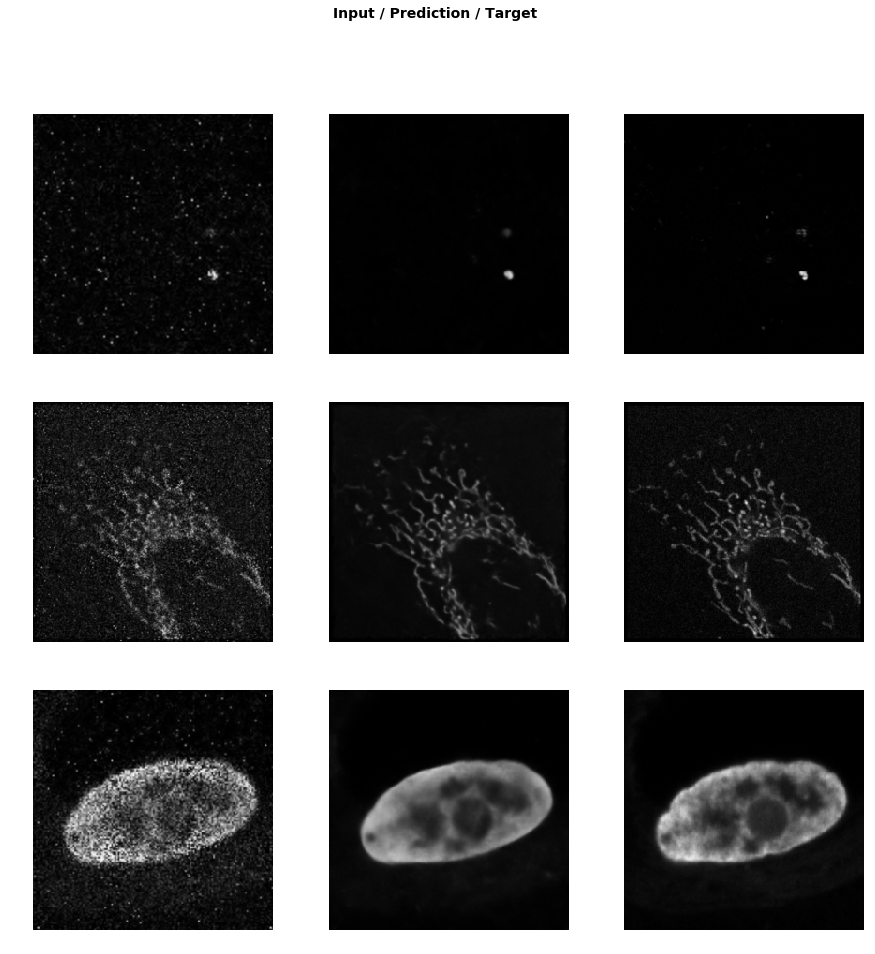

In [16]:
do_fit(f'{nb_name}.2', lr/100, cycle_len=100)

In [17]:
learn.unfreeze()

Better model found at epoch 0 with val_loss value: 0.02395555004477501.
Better model found at epoch 1 with val_loss value: 0.023945115506649017.
Better model found at epoch 11 with val_loss value: 0.023941099643707275.
Better model found at epoch 26 with val_loss value: 0.023931678384542465.
Better model found at epoch 28 with val_loss value: 0.023916296660900116.
Better model found at epoch 48 with val_loss value: 0.023912496864795685.
Better model found at epoch 49 with val_loss value: 0.023888006806373596.


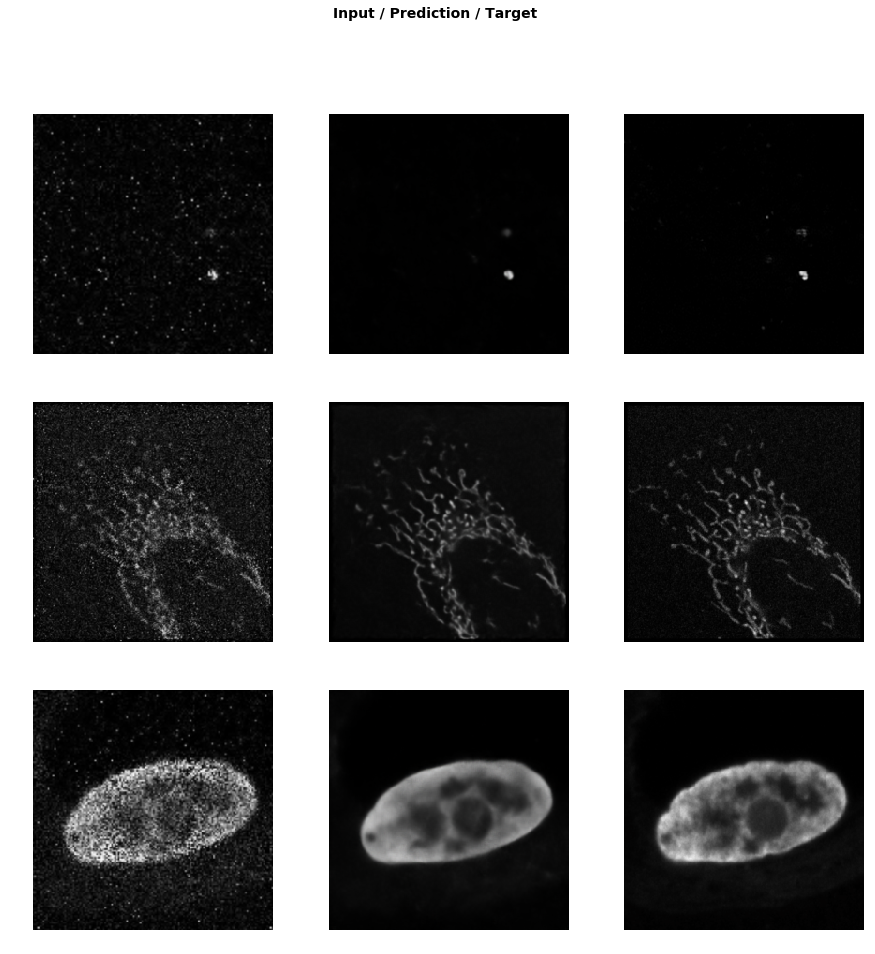

In [18]:
do_fit(f'{nb_name}.3', slice(1e-5,lr/10), cycle_len=50)

In [18]:
bs = 4
size = 512
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)

learn = learn.load(f'{nb_name}.3')
gc.collect()

/scratch/bpho/datasets/synth_newcrap_002/lr_up


0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


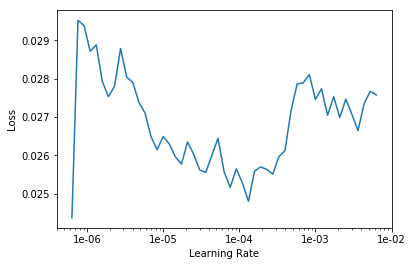

In [16]:
learn.lr_find()
learn.recorder.plot()

In [10]:
lr

0.001

Better model found at epoch 0 with val_loss value: 0.026448899880051613.


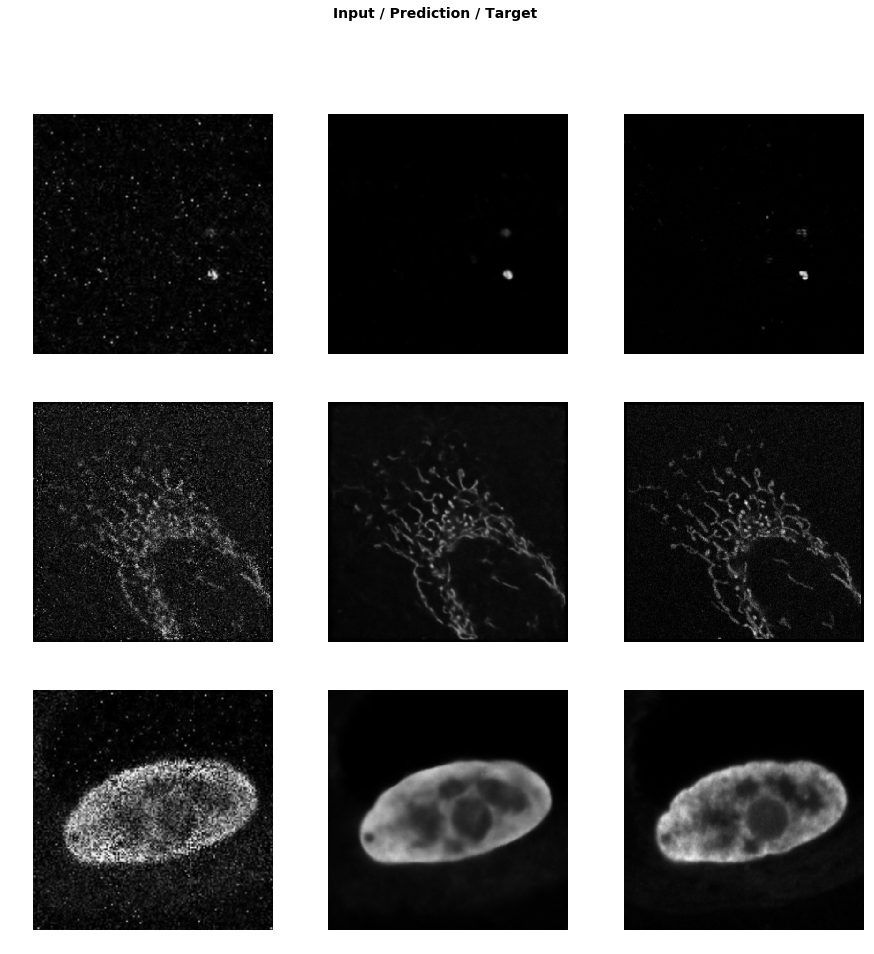

In [17]:
do_fit(f'{nb_name}.4', lr/100, cycle_len=2) #was 100, messed up.

In [12]:
learn.unfreeze()

Better model found at epoch 0 with val_loss value: 0.026370445266366005.
Better model found at epoch 3 with val_loss value: 0.026338979601860046.
Better model found at epoch 6 with val_loss value: 0.02628849446773529.
Better model found at epoch 38 with val_loss value: 0.026252252981066704.


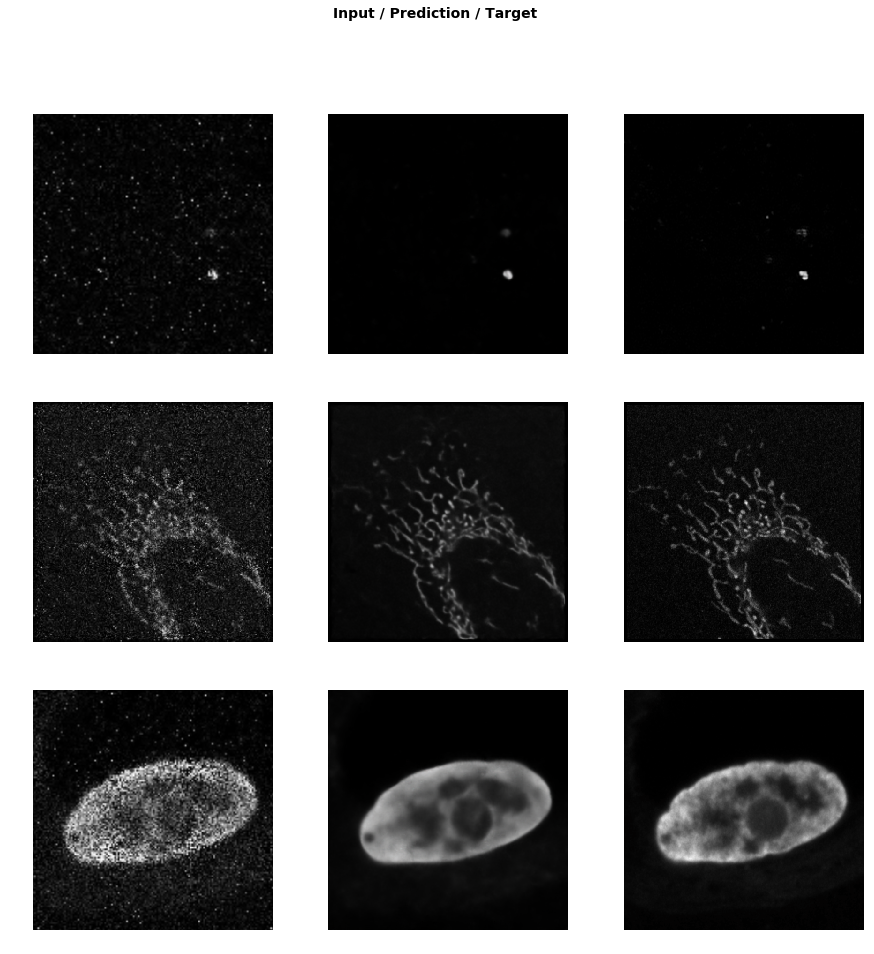

In [13]:
do_fit(f'{nb_name}.5', slice(1e-6,lr/100), cycle_len=50)

In [11]:
bs = 1
size = 1024
data = get_data(bs, size, max_zoom=2.)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, #callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()

learn = learn.load(f'{nb_name}.5')

/scratch/bpho/datasets/synth_newcrap_002/lr_up


Better model found at epoch 0 with val_loss value: 0.028599614277482033.
Better model found at epoch 1 with val_loss value: 0.028227562084794044.
Better model found at epoch 2 with val_loss value: 0.02806706167757511.
Better model found at epoch 5 with val_loss value: 0.028061414137482643.


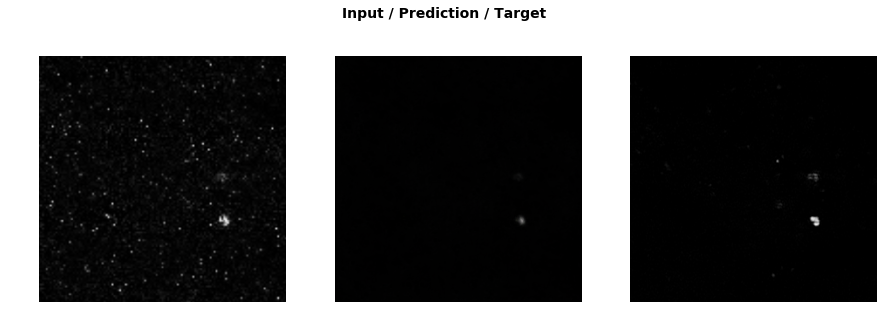

In [12]:
do_fit(f'{nb_name}.6', lr/100, cycle_len=10)

In [13]:
learn.unfreeze()

Better model found at epoch 0 with val_loss value: 0.03008284419775009.
Better model found at epoch 1 with val_loss value: 0.028743857517838478.
Better model found at epoch 6 with val_loss value: 0.02847345359623432.


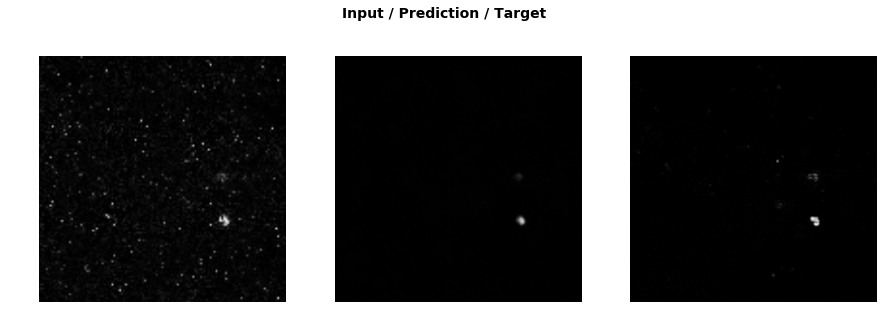

In [14]:
do_fit(f'{nb_name}.7', slice(1e-6,lr/100), cycle_len=10)

In [15]:
print('cool')

cool


In [ ]:
!ls /scratch/bpho/models/{nb_name}*

In [16]:
test_path = Path('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/')
!ls {test_path}

'high res 125 time points 1.czi'
'high res airyscan 300 time points 11 raw lots of good mitos after refocusing-Airyscan Processing-01.czi'
'high res airyscan 300 time points 2 raw-Airyscan Processing-01.czi'
'high res airyscan 300 time points 3 raw-Airyscan Processing-02.czi'
'high res airyscan 300 time points 4 raw-Airyscan Processing-03.czi'
'high res airyscan 300 time points 5 raw-Airyscan Processing-04.czi'
'high res airyscan 300 time points 6 raw-Airyscan Processing-05.czi'
'high res airyscan 300 time points 7 raw-Airyscan Processing-06.czi'
'high res airyscan 300 time points 8 raw-Airyscan Processing-07.czi'
'low res 1200 time points 10 high signal.czi'
'low res 1200 time points 11 high signal.czi'
'low res 1200 time points 9 high signal.czi'
'low res 1500 time points 7.czi'
'low res 1500 time points 8.czi'
'low res 1500 time points 8 redo best.czi'
'low res 2000 time points 1.czi'
'low res 300 time points 2.czi'
'low res 300 time points 3.czi'
'low res 300 time points 4.czi'
'lo

In [17]:
#movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))
movie_files = list(test_path.glob('low*.czi'))
movie_files

[PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1500 time points 8.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 300 time points 2.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1500 time points 7.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 2000 time points 1.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1200 time points 10 high signal.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 300 time points 3.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1200 time points 9 high signal.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_redo_for_Gulcin_and_Fred/low res 1500 time points 8 redo best.czi'),
 PosixPath('/scratch/bpho/datasources/Live_Neuron_Data_

In [18]:
fn = movie_files[0]
len(movie_files)

12

In [20]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [21]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)

        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)


In [ ]:
bs=1
#size=1024
size=380*4
scale = 4

data = get_data(bs, size, tile_size=128)

arch = models.resnet18
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     metrics=superres_metrics, callback_fns=LossMetrics, 
                     blur=True, blur_final=True, norm_type=NormType.Weight, 
                     self_attention=True, last_cross=True, bottle=True,
                     #y_range=(0.,1.),
                     model_dir=model_path)
gc.collect()
learn = learn.load(f'{nb_name}.7')


In [ ]:
#learn.export(model_path/'paired_001_unet.8.pkl')
#learn = load_learner(model_path, 'paired_001_unet.8.pkl')

In [ ]:
for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif'
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

In [ ]:
learn.pred_batch()

In [ ]:
import skimage.util as u

In [ ]:
u.img_as_ubyte